In [1]:
!pip -q install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.7 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import zipfile
import os, glob, random
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import yaml
import pandas as pd
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import seaborn as sns
from PIL import Image
from collections import Counter

sns.set_style("whitegrid")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
zip= Path("/content/BCCD.zip")
out= Path("/content")

with zipfile.ZipFile(zip, "r") as z:
    z.extractall(out)

In [4]:
def parse_xml(xml_path):
    """Extrai informações de um arquivo XML de anotação"""
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find('filename').text
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    objects = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        objects.append({
            'filename': filename,
            'img_width': width,
            'img_height': height,
            'class': class_name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax,
            'bbox_width': xmax - xmin,
            'bbox_height': ymax - ymin
        })

    return objects


annotations_dir = 'BCCD/Annotations'
all_annotations = []

for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith('.xml'):
        xml_path = os.path.join(annotations_dir, xml_file)
        all_annotations.extend(parse_xml(xml_path))

df = pd.DataFrame(all_annotations)
print(f"Total de anotações: {len(df)}")
print(f"Total de imagens: {df['filename'].nunique()}")
df.head()

Total de anotações: 4888
Total de imagens: 364


,filename,img_width,img_height,class,xmin,ymin,xmax,ymax,bbox_width,bbox_height
0,BloodImage_00273.jpg,640,480,RBC,227,265,329,359,102,94
1,BloodImage_00273.jpg,640,480,RBC,48,211,159,306,111,95
2,BloodImage_00273.jpg,640,480,RBC,136,167,271,282,135,115
3,BloodImage_00273.jpg,640,480,RBC,388,275,500,386,112,111
4,BloodImage_00273.jpg,640,480,RBC,491,286,606,387,115,101


=== DIMENSÕES DAS IMAGENS ===
Largura - Média: 640.0, Min: 640, Max: 640
Altura - Média: 480.0, Min: 480, Max: 480


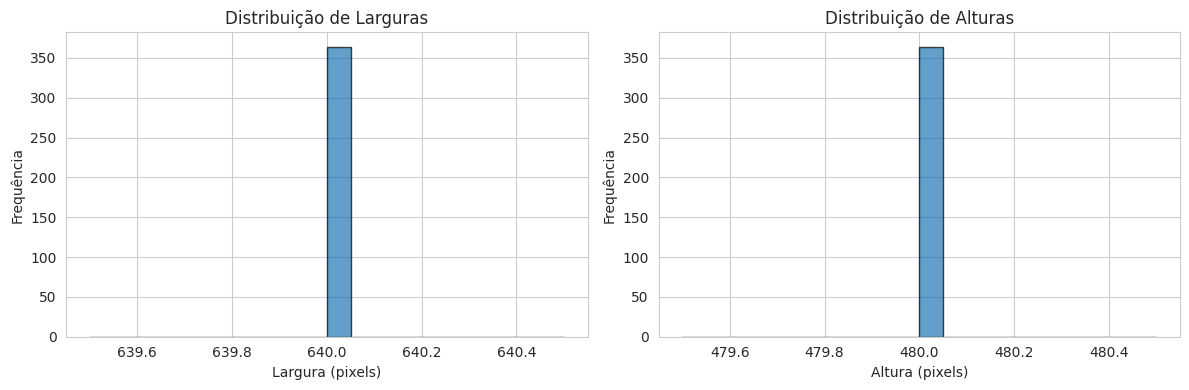

In [5]:
img_sizes = df[['filename', 'img_width', 'img_height']].drop_duplicates()

print("=== DIMENSÕES DAS IMAGENS ===")
print(f"Largura - Média: {img_sizes['img_width'].mean():.1f}, Min: {img_sizes['img_width'].min()}, Max: {img_sizes['img_width'].max()}")
print(f"Altura - Média: {img_sizes['img_height'].mean():.1f}, Min: {img_sizes['img_height'].min()}, Max: {img_sizes['img_height'].max()}")


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(img_sizes['img_width'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Largura (pixels)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição de Larguras')

axes[1].hist(img_sizes['img_height'], bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Altura (pixels)')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição de Alturas')

plt.tight_layout()
plt.show()

=== DISTRIBUIÇÃO DE CLASSES ===
class
RBC          4155
WBC           372
Platelets     361
Name: count, dtype: int64

Total de objetos: 4888


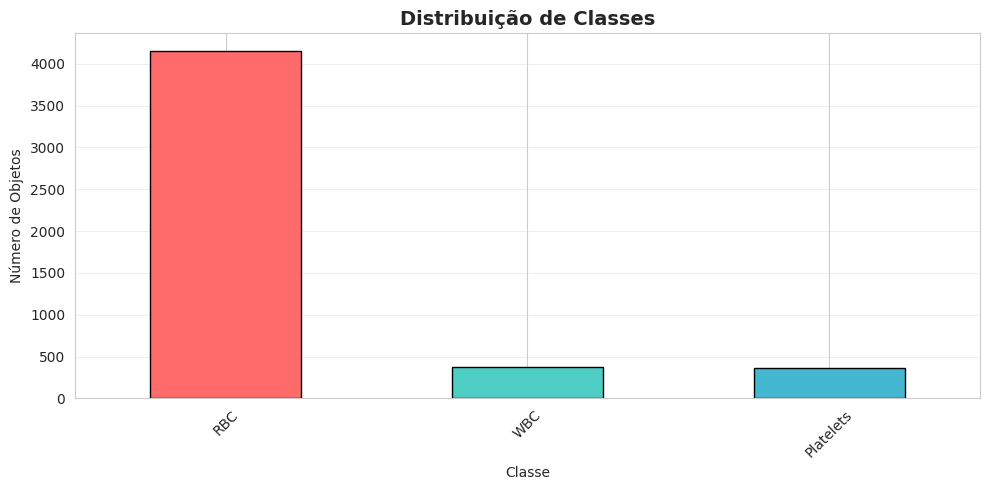

In [6]:
print("=== DISTRIBUIÇÃO DE CLASSES ===")
class_counts = df['class'].value_counts()
print(class_counts)
print(f"\nTotal de objetos: {len(df)}")

plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black')
plt.title('Distribuição de Classes', fontsize=14, fontweight='bold')
plt.xlabel('Classe')
plt.ylabel('Número de Objetos')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

=== OBJETOS POR IMAGEM ===
Média: 13.43
Mediana: 14.0
Min: 1
Max: 30


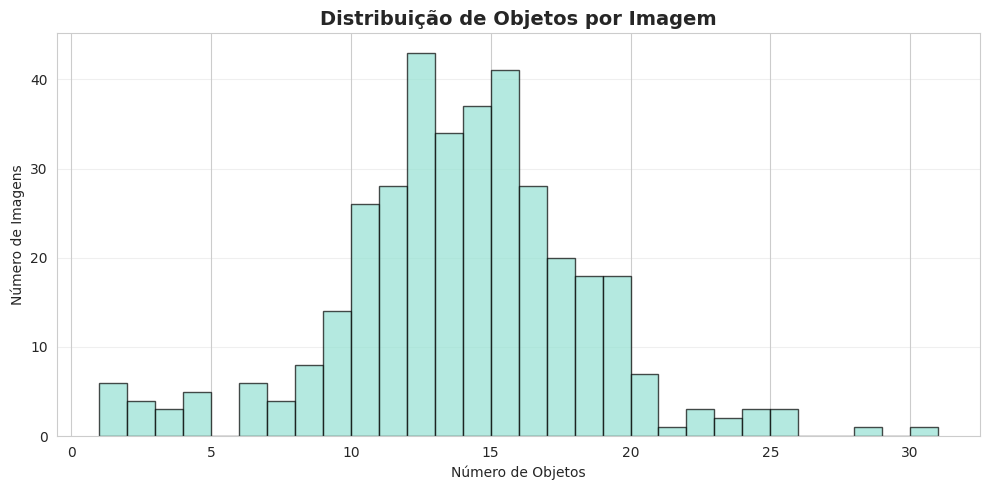

In [7]:
objects_per_image = df.groupby('filename').size()

print("=== OBJETOS POR IMAGEM ===")
print(f"Média: {objects_per_image.mean():.2f}")
print(f"Mediana: {objects_per_image.median():.1f}")
print(f"Min: {objects_per_image.min()}")
print(f"Max: {objects_per_image.max()}")

plt.figure(figsize=(10, 5))
plt.hist(objects_per_image, bins=range(objects_per_image.min(), objects_per_image.max()+2),
         edgecolor='black', alpha=0.7, color='#95E1D3')
plt.xlabel('Número de Objetos')
plt.ylabel('Número de Imagens')
plt.title('Distribuição de Objetos por Imagem', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

=== TAMANHO DAS BOUNDING BOXES ===
Largura - Média: 106.6, Min: 0, Max: 338
Altura - Média: 101.6, Min: 0, Max: 286

Aspect Ratio - Média: 1.07, Min: 0.33, Max: 2.70


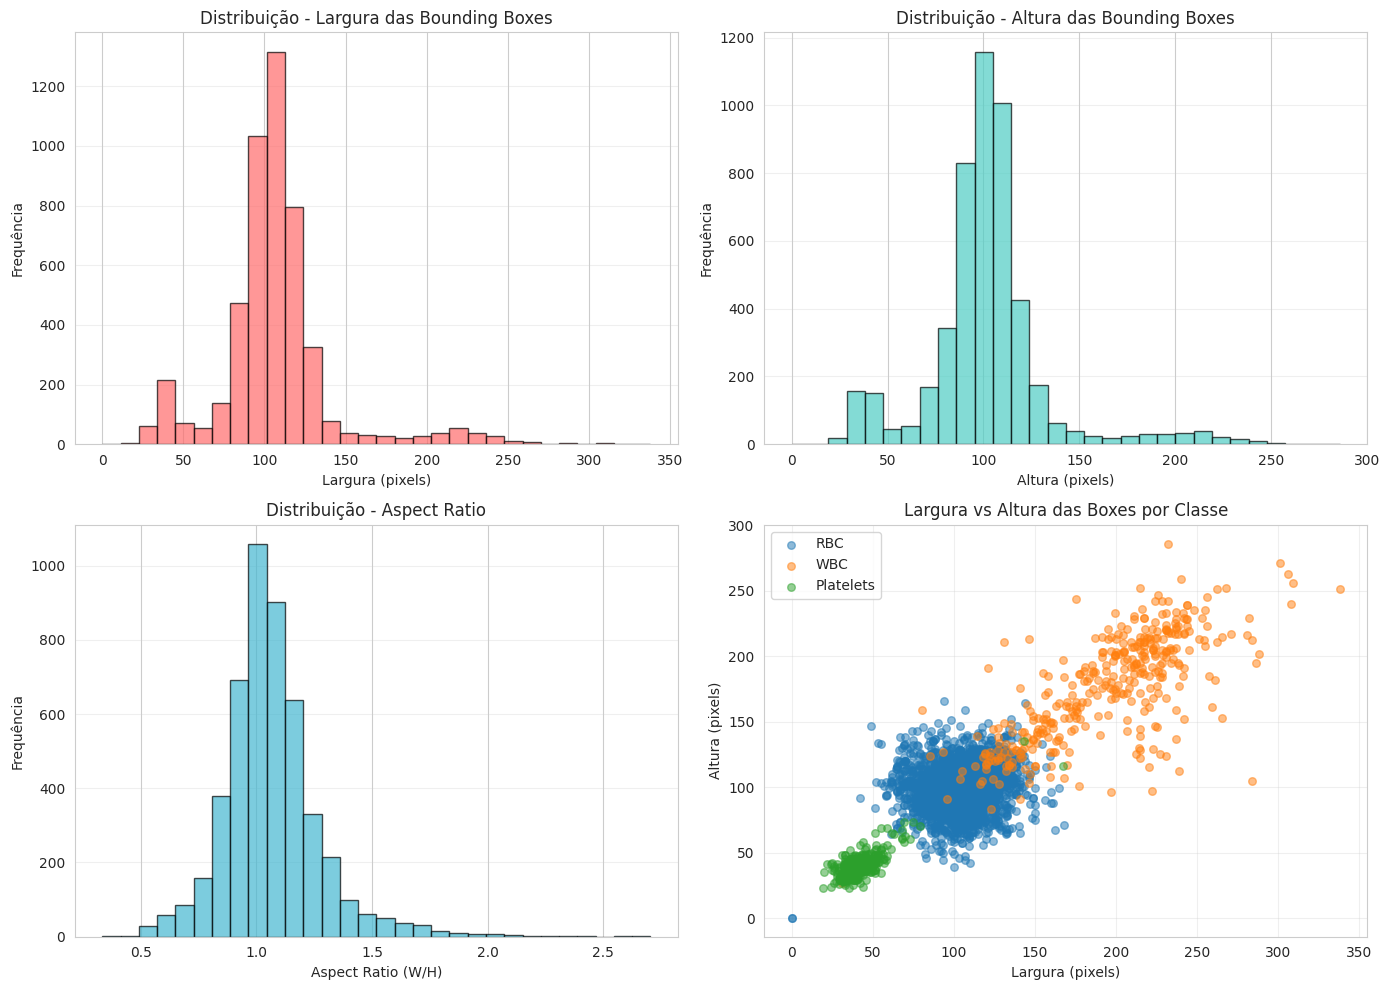

In [8]:
print("=== TAMANHO DAS BOUNDING BOXES ===")
print(f"Largura - Média: {df['bbox_width'].mean():.1f}, Min: {df['bbox_width'].min()}, Max: {df['bbox_width'].max()}")
print(f"Altura - Média: {df['bbox_height'].mean():.1f}, Min: {df['bbox_height'].min()}, Max: {df['bbox_height'].max()}")

df['aspect_ratio'] = df['bbox_width'] / df['bbox_height']
print(f"\nAspect Ratio - Média: {df['aspect_ratio'].mean():.2f}, Min: {df['aspect_ratio'].min():.2f}, Max: {df['aspect_ratio'].max():.2f}")


fig, axes = plt.subplots(2, 2, figsize=(14, 10))


axes[0, 0].hist(df['bbox_width'], bins=30, edgecolor='black', alpha=0.7, color='#FF6B6B')
axes[0, 0].set_xlabel('Largura (pixels)')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].set_title('Distribuição - Largura das Bounding Boxes')
axes[0, 0].grid(axis='y', alpha=0.3)


axes[0, 1].hist(df['bbox_height'], bins=30, edgecolor='black', alpha=0.7, color='#4ECDC4')
axes[0, 1].set_xlabel('Altura (pixels)')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Distribuição - Altura das Bounding Boxes')
axes[0, 1].grid(axis='y', alpha=0.3)


axes[1, 0].hist(df['aspect_ratio'], bins=30, edgecolor='black', alpha=0.7, color='#45B7D1')
axes[1, 0].set_xlabel('Aspect Ratio (W/H)')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].set_title('Distribuição - Aspect Ratio')
axes[1, 0].grid(axis='y', alpha=0.3)


for class_name in df['class'].unique():
    class_df = df[df['class'] == class_name]
    axes[1, 1].scatter(class_df['bbox_width'], class_df['bbox_height'],
                      alpha=0.5, label=class_name, s=30)
axes[1, 1].set_xlabel('Largura (pixels)')
axes[1, 1].set_ylabel('Altura (pixels)')
axes[1, 1].set_title('Largura vs Altura das Boxes por Classe')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
import os
import shutil
from pathlib import Path
import xml.etree.ElementTree as ET

base_dir = Path("/content/BCCD_YOLO_VAL")
val_img_dir = base_dir / "images" / "val"
val_lbl_dir = base_dir / "labels" / "val"

val_img_dir.mkdir(parents=True, exist_ok=True)
val_lbl_dir.mkdir(parents=True, exist_ok=True)


class_map = {'WBC': 0, 'RBC': 1, 'Platelets': 2}

def xml_to_yolo(xml_path, img_width, img_height):
    """Converte XML para formato YOLO"""
    tree = ET.parse(xml_path)
    root = tree.getroot()

    yolo_annotations = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_map:
            continue

        class_id = class_map[class_name]
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return yolo_annotations


img_dir = Path("/content/BCCD/JPEGImages")
ann_dir = Path("/content/BCCD/Annotations")

converted = 0

for img_path in img_dir.glob("*.jpg"):
    xml_path = ann_dir / f"{img_path.stem}.xml"

    if not xml_path.exists():
        continue


    shutil.copy(img_path, val_img_dir / img_path.name)


    tree = ET.parse(xml_path)
    root = tree.getroot()
    size = root.find('size')
    img_width = int(size.find('width').text)
    img_height = int(size.find('height').text)

    yolo_annotations = xml_to_yolo(xml_path, img_width, img_height)


    label_path = val_lbl_dir / f"{img_path.stem}.txt"
    with open(label_path, 'w') as f:
        f.write('\n'.join(yolo_annotations))

    converted += 1

print(f"{converted} imagens convertidas para validação")


yaml_content = f"""
path: /content/BCCD_YOLO_VAL
train: # não usado
val: images/val
test: # não usado

names:
  0: WBC
  1: RBC
  2: Platelets
"""

yaml_path = "/content/bccd_val_only.yaml"
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"\n YAML criado: {yaml_path}")
print(f" Dataset em: {base_dir}")
print(f"Total de imagens: {converted}")

364 imagens convertidas para validação

 YAML criado: /content/bccd_val_only.yaml
 Dataset em: /content/BCCD_YOLO_VAL
Total de imagens: 364


In [10]:
import shutil
from pathlib import Path

shutil.make_archive('/content/BCCD_VAL', 'zip', '/content/BCCD_YOLO_VAL')

'/content/BCCD_VAL.zip'